 Importaciones completadas
 Dataset cargado exitosamente:
   • Muestras: 10,000
   • Características: 48
   • Clases: [0 1]
   • Distribución de clases: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000)}
 Análisis exploratorio de PCA:
   • Varianza total explicada: 1.000000
   • Primer componente explica: 0.101 de la varianza
   • Eigenvalue máximo: 4.743
   • Eigenvalues > 1: 16 componentes
 CRITERIO 1: VARIANZA EXPLICADA
--------------------------------------------------
  📊 90%: 30 componentes ( 37.5% reducción)
  📊 95%: 34 componentes ( 29.2% reducción)
  📊 99%: 41 componentes ( 14.6% reducción)

 CRITERIO 2: ELBOW METHOD
--------------------------------------------------
   Codo detectado: 12 componentes ( 75.0% reducción)
     └─ Método curvatura: 4 componentes
     └─ Método distancia: 20 componentes

 CRITERIO 3: KAISER RULE (Eigenvalues > 1)
--------------------------------------------------
    Kaiser Rule: 16 componentes ( 66.7% reducción)

 CRITERIO 4: NÚMEROS FIJOS

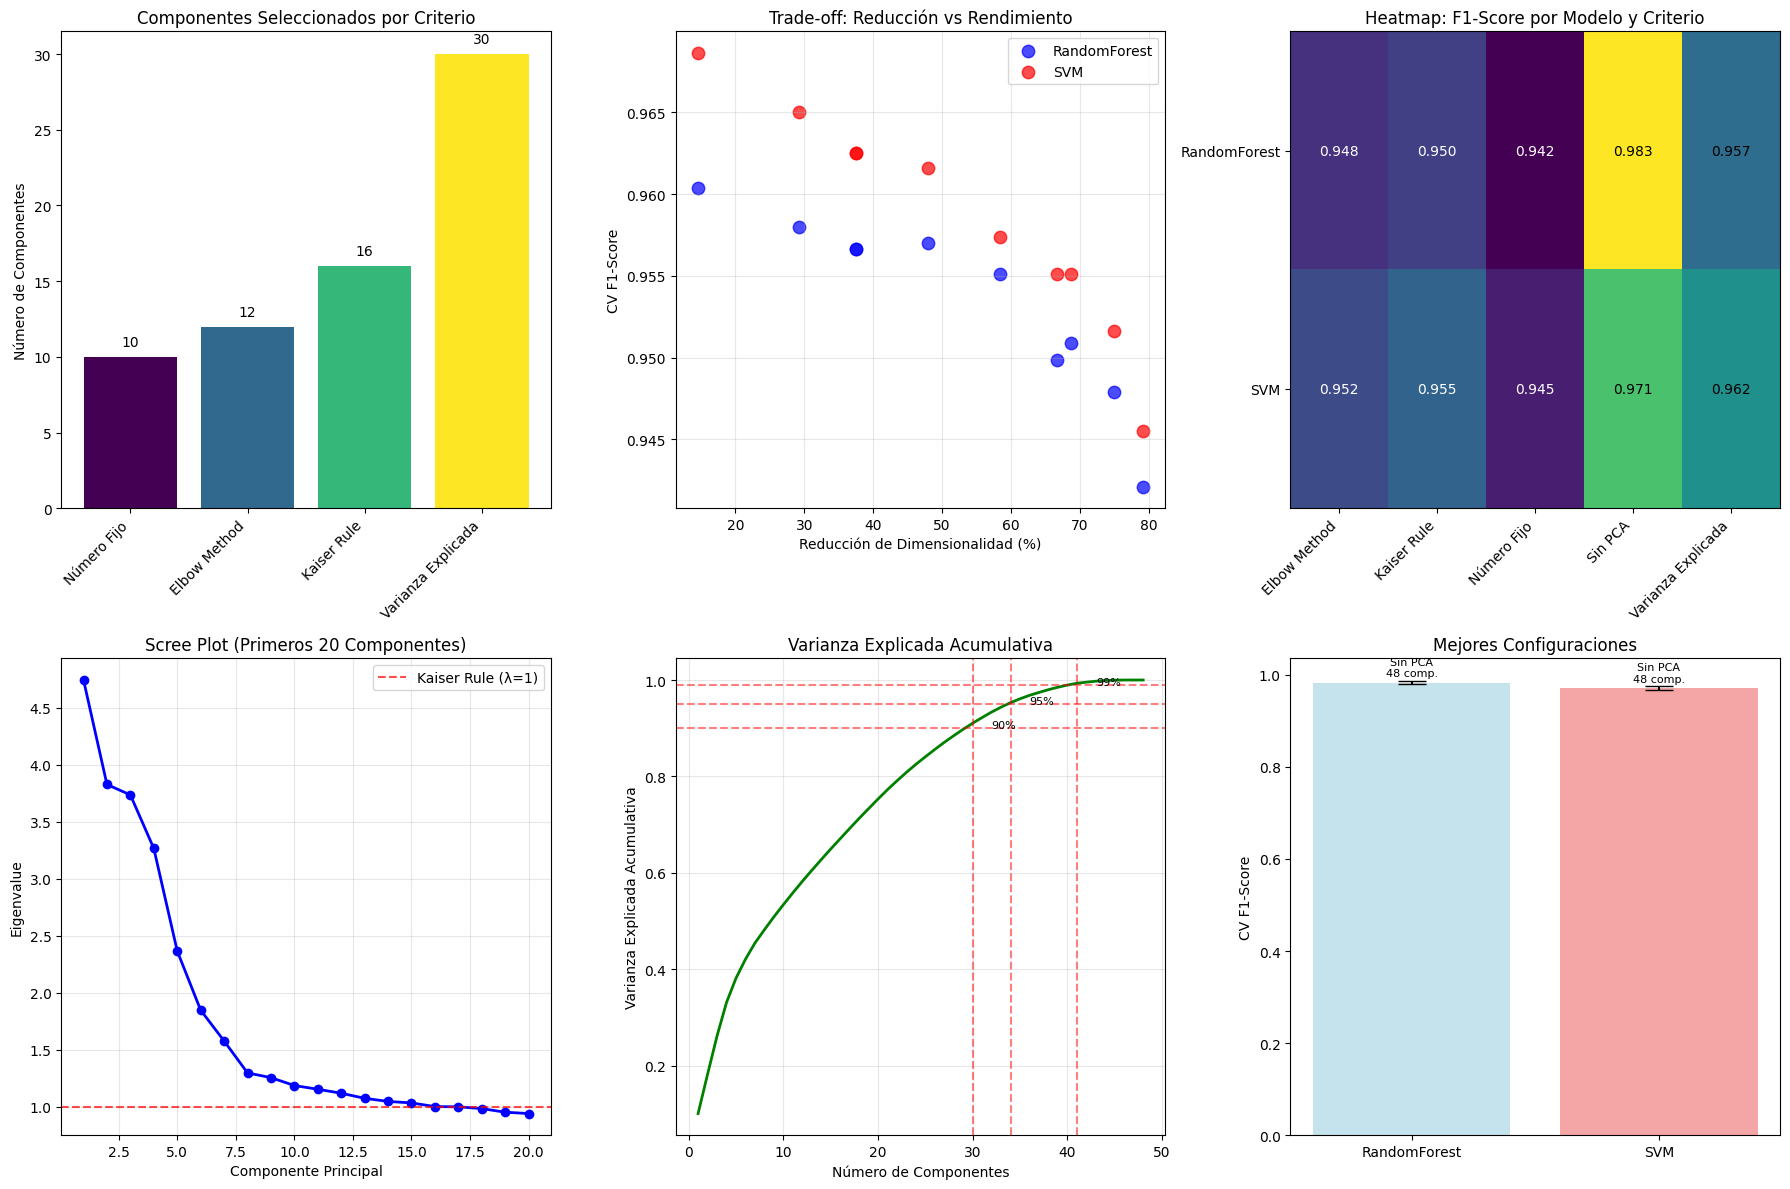


 CONCLUSIONES
 CONFIGURACIÓN ÓPTIMA:
   └─ Modelo: RandomForest
   └─ Criterio PCA: Sin PCA (Baseline)
   └─ Componentes: 48/48
   └─ Reducción: 0.0%
   └─ CV F1-Score: 0.9829 ± 0.0037
   └─ Mejora vs Sin PCA: +0.00%

 ¿Cómo afecta la selección de más/menos características al rendimiento?
    Conservador (Varianza Explicada): F1 = 0.9619
    Agresivo (Número Fijo): F1 = 0.9544
    Diferencia: 0.0075

 Elbow Method vs Kaiser Rule
 Kaiser Rule es superior: 0.9525 vs 0.9497

 Conclusión final:
    NO aplicar PCA - El modelo sin reducción de dimensionalidad es superior
    Las 48 características originales contienen información valiosa


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print(" Importaciones completadas")


# 2. Carga y Exploración del Dataset

# Cargar dataset
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"

try:
    df = pd.read_csv(url)
    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    X = df.drop(columns=['CLASS_LABEL'])
    y = df['CLASS_LABEL']

    print(f" Dataset cargado exitosamente:")
    print(f"   • Muestras: {X.shape[0]:,}")
    print(f"   • Características: {X.shape[1]}")
    print(f"   • Clases: {np.unique(y)}")
    print(f"   • Distribución de clases: {dict(zip(*np.unique(y, return_counts=True)))}")

except Exception as e:
    print(f" Error cargando datos: {e}")
    print("Por favor, verifica la URL del dataset")

# 3. Análisis Exploratorio de Componentes Principales

# Preparación de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Estandarización (crítica para PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA completo para análisis exploratorio
pca_full = PCA(random_state=42)
pca_full.fit(X_train_scaled)

eigenvalues = pca_full.explained_variance_
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f" Análisis exploratorio de PCA:")
print(f"   • Varianza total explicada: {cumulative_variance[-1]:.6f}")
print(f"   • Primer componente explica: {explained_variance_ratio[0]:.3f} de la varianza")
print(f"   • Eigenvalue máximo: {eigenvalues[0]:.3f}")
print(f"   • Eigenvalues > 1: {np.sum(eigenvalues > 1)} componentes")

# 4. Implementación de Múltiples Criterios PCA

def calculate_elbow_point(explained_variance_ratio):
    """
    Implementa el método de codo usando análisis de curvatura
    """
    n_components = len(explained_variance_ratio)
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Método 1: Segunda derivada (curvatura máxima)
    first_diff = np.diff(cumulative_variance)
    second_diff = np.diff(first_diff)
    elbow_curvature = np.argmax(np.abs(second_diff)) + 2

    # Método 2: Distancia punto-línea
    start_point = np.array([0, cumulative_variance[0]])
    end_point = np.array([n_components-1, cumulative_variance[-1]])

    distances = []
    for i in range(n_components):
        point = np.array([i, cumulative_variance[i]])
        distance = np.abs(np.cross(end_point - start_point, start_point - point)) / np.linalg.norm(end_point - start_point)
        distances.append(distance)

    elbow_distance = np.argmax(distances)

    # Promedio de ambos métodos
    elbow_final = int(np.mean([elbow_curvature, elbow_distance]))
    elbow_final = max(1, min(elbow_final, n_components))

    return elbow_final, elbow_curvature, elbow_distance

def evaluate_all_pca_criteria():
    """
    Evalúa todos los criterios PCA implementados
    """
    criteria_results = []

    # 1. CRITERIO: VARIANZA EXPLICADA
    variance_thresholds = [0.90, 0.95, 0.99]

    print(" CRITERIO 1: VARIANZA EXPLICADA")
    print("-" * 50)

    for threshold in variance_thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        variance_achieved = cumulative_variance[n_components-1]
        reduction_percent = (1 - n_components / X.shape[1]) * 100

        result = {
            'criterion': 'Varianza Explicada',
            'criterion_value': f'{threshold:.0%}',
            'n_components': n_components,
            'variance_explained': variance_achieved,
            'reduction_percent': reduction_percent,
            'eigenvalue_cutoff': eigenvalues[n_components-1]
        }

        criteria_results.append(result)
        print(f"  📊 {threshold:.0%}: {n_components:2d} componentes ({reduction_percent:5.1f}% reducción)")

    # 2. CRITERIO: ELBOW METHOD
    print(f"\n CRITERIO 2: ELBOW METHOD")
    print("-" * 50)

    elbow_final, elbow_curvature, elbow_distance = calculate_elbow_point(explained_variance_ratio)
    variance_elbow = cumulative_variance[elbow_final-1]
    reduction_elbow = (1 - elbow_final / X.shape[1]) * 100

    result_elbow = {
        'criterion': 'Elbow Method',
        'criterion_value': 'Codo Detectado',
        'n_components': elbow_final,
        'variance_explained': variance_elbow,
        'reduction_percent': reduction_elbow,
        'eigenvalue_cutoff': eigenvalues[elbow_final-1]
    }

    criteria_results.append(result_elbow)
    print(f"   Codo detectado: {elbow_final:2d} componentes ({reduction_elbow:5.1f}% reducción)")
    print(f"     └─ Método curvatura: {elbow_curvature} componentes")
    print(f"     └─ Método distancia: {elbow_distance} componentes")

    # 3. CRITERIO: KAISER RULE
    print(f"\n CRITERIO 3: KAISER RULE (Eigenvalues > 1)")
    print("-" * 50)

    n_components_kaiser = np.sum(eigenvalues > 1)
    if n_components_kaiser == 0:
        n_components_kaiser = 1

    variance_kaiser = cumulative_variance[n_components_kaiser-1]
    reduction_kaiser = (1 - n_components_kaiser / X.shape[1]) * 100

    result_kaiser = {
        'criterion': 'Kaiser Rule',
        'criterion_value': f'λ > 1 ({np.sum(eigenvalues > 1)} eigenvalues)',
        'n_components': n_components_kaiser,
        'variance_explained': variance_kaiser,
        'reduction_percent': reduction_kaiser,
        'eigenvalue_cutoff': eigenvalues[n_components_kaiser-1] if n_components_kaiser <= len(eigenvalues) else 0
    }

    criteria_results.append(result_kaiser)
    print(f"    Kaiser Rule: {n_components_kaiser:2d} componentes ({reduction_kaiser:5.1f}% reducción)")

    # 4. CRITERIO: NÚMEROS FIJOS
    print(f"\n CRITERIO 4: NÚMEROS FIJOS (Literatura)")
    print("-" * 50)

    fixed_numbers = [10, 15, 20, 25, 30]

    for n_fixed in fixed_numbers:
        if n_fixed >= X.shape[1]:
            continue

        variance_fixed = cumulative_variance[n_fixed-1]
        reduction_fixed = (1 - n_fixed / X.shape[1]) * 100

        result_fixed = {
            'criterion': 'Número Fijo',
            'criterion_value': f'{n_fixed} componentes',
            'n_components': n_fixed,
            'variance_explained': variance_fixed,
            'reduction_percent': reduction_fixed,
            'eigenvalue_cutoff': eigenvalues[n_fixed-1]
        }

        criteria_results.append(result_fixed)
        print(f"  📖 {n_fixed:2d} componentes: {variance_fixed:.3f} varianza ({reduction_fixed:5.1f}% reducción)")

    return criteria_results

# Ejecutar evaluación de criterios
criteria_results = evaluate_all_pca_criteria()

# 5. Tabla Comparativa de Criterios

# Crear tabla comparativa de criterios
df_criteria = pd.DataFrame(criteria_results)

print(f"\n TABLA COMPARATIVA DE CRITERIOS PCA")
print("="*80)
print(df_criteria.to_string(index=False, float_format='%.3f'))

# Estadísticas resumen
print(f"\n ESTADÍSTICAS RESUMEN:")
print(f"• Componentes - Rango: {df_criteria['n_components'].min()}-{df_criteria['n_components'].max()}")
print(f"• Reducción - Rango: {df_criteria['reduction_percent'].min():.1f}%-{df_criteria['reduction_percent'].max():.1f}%")
print(f"• Varianza - Rango: {df_criteria['variance_explained'].min():.3f}-{df_criteria['variance_explained'].max():.3f}")

# Criterios extremos
most_conservative = df_criteria.loc[df_criteria['n_components'].idxmax()]
most_aggressive = df_criteria.loc[df_criteria['n_components'].idxmin()]

print(f"\n MÁS AGRESIVO: {most_aggressive['criterion']} - {most_aggressive['n_components']} comp. ({most_aggressive['reduction_percent']:.1f}% reducción)")
print(f"  MÁS CONSERVADOR: {most_conservative['criterion']} - {most_conservative['n_components']} comp. ({most_conservative['reduction_percent']:.1f}% reducción)")

# 6. Evaluación de Modelos con PCA

# Hiperparámetros optimizados (obtenidos de experimentos previos)
best_rf_params = {
    'n_estimators': 157,
    'max_depth': 27,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': False,
    'random_state': 42,
    'n_jobs': -1
}

best_svm_params = {
    'C': 14.403910932208483,
    'kernel': 'rbf',
    'shrinking': True,
    'class_weight': None,
    'gamma': 'scale',
    'random_state': 42
}

def evaluate_models_with_pca(criteria_results):
    """
    Evalúa Random Forest y SVM con todos los criterios PCA
    """
    models = {
        'RandomForest': RandomForestClassifier(**best_rf_params),
        'SVM': SVC(**best_svm_params)
    }

    evaluation_results = []

    print(f"EVALUACIÓN DE MODELOS CON PCA")
    print("="*60)

    # Evaluación baseline (sin PCA)
    print(f"\n Evaluación BASELINE (sin PCA)")
    print("-" * 40)

    for model_name, model in models.items():
        # Entrenar y evaluar
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Validación cruzada
        cv_scores = cross_val_score(
            model, X_train_scaled, y_train,
            cv=5, scoring='f1_weighted', n_jobs=-1
        )

        result = {
            'model': model_name,
            'criterion': 'Sin PCA',
            'criterion_value': 'Baseline',
            'n_components': X.shape[1],
            'variance_explained': 1.0,
            'reduction_percent': 0.0,
            'accuracy': accuracy,
            'f1_score': f1,
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std()
        }

        evaluation_results.append(result)

        print(f" {model_name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, CV F1={cv_scores.mean():.4f}±{cv_scores.std():.4f}")

    # Evaluación con cada criterio PCA
    for i, pca_config in enumerate(criteria_results):
        criterion = pca_config['criterion']
        criterion_value = pca_config['criterion_value']
        n_components = pca_config['n_components']

        print(f"\n Evaluación con {criterion} ({criterion_value}) - {n_components} componentes")
        print("-" * 50)

        # Aplicar PCA
        pca = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        for model_name, base_model in models.items():
            # Crear nuevo modelo
            if model_name == 'RandomForest':
                model_pca = RandomForestClassifier(**best_rf_params)
            else:
                model_pca = SVC(**best_svm_params)

            # Entrenar y evaluar
            model_pca.fit(X_train_pca, y_train)
            y_pred = model_pca.predict(X_test_pca)

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Validación cruzada
            cv_scores = cross_val_score(
                model_pca, X_train_pca, y_train,
                cv=5, scoring='f1_weighted', n_jobs=-1
            )

            result = {
                'model': model_name,
                'criterion': criterion,
                'criterion_value': criterion_value,
                'n_components': n_components,
                'variance_explained': pca_config['variance_explained'],
                'reduction_percent': pca_config['reduction_percent'],
                'accuracy': accuracy,
                'f1_score': f1,
                'cv_f1_mean': cv_scores.mean(),
                'cv_f1_std': cv_scores.std()
            }

            evaluation_results.append(result)

            print(f"  {model_name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, CV F1={cv_scores.mean():.4f}±{cv_scores.std():.4f}")

    return evaluation_results

# Ejecutar evaluación de modelos
evaluation_results = evaluate_models_with_pca(criteria_results)

# 7. Análisis de Resultados

# Convertir a DataFrame para análisis
df_results = pd.DataFrame(evaluation_results)

print(f"\n TABLA COMPLETA DE RESULTADOS")
print("="*100)

# Mostrar tabla formateada
display_cols = ['model', 'criterion', 'criterion_value', 'n_components',
                'reduction_percent', 'cv_f1_mean', 'cv_f1_std']
print(df_results[display_cols].to_string(index=False, float_format='%.4f'))

# 8. Análisis Específico: ¿Qué Criterio Selecciona Más Características?

print(f"\n ANÁLISIS: ¿QUÉ CRITERIO SELECCIONA MÁS CARACTERÍSTICAS?")
print("="*60)

# Filtrar solo resultados con PCA
pca_results = df_results[df_results['criterion'] != 'Sin PCA'].copy()

# Agrupar por criterio
criteria_summary = pca_results.groupby('criterion').agg({
    'n_components': 'first',
    'reduction_percent': 'first',
    'variance_explained': 'first',
    'cv_f1_mean': 'mean'
}).round(4)

# Ordenar por número de componentes (descendente)
criteria_summary = criteria_summary.sort_values('n_components', ascending=False)

print(f" RANKING DE CRITERIOS POR NÚMERO DE COMPONENTES:")
print("-" * 60)
for i, (criterion, row) in enumerate(criteria_summary.iterrows(), 1):
    print(f"{i}. {criterion}: {row['n_components']} componentes "
          f"({row['reduction_percent']:.1f}% reducción, F1 promedio: {row['cv_f1_mean']:.4f})")

# Identificar extremos
most_components_criterion = criteria_summary.index[0]
least_components_criterion = criteria_summary.index[-1]

print(f"\n CRITERIO MÁS CONSERVADOR (más características):")
most_conservative = criteria_summary.loc[most_components_criterion]
print(f"   └─ {most_components_criterion}: {most_conservative['n_components']} componentes")
print(f"   └─ Reducción: {most_conservative['reduction_percent']:.1f}%")
print(f"   └─ Varianza: {most_conservative['variance_explained']:.3f}")
print(f"   └─ F1-Score promedio: {most_conservative['cv_f1_mean']:.4f}")

print(f"\n CRITERIO MÁS AGRESIVO (menos características):")
most_aggressive = criteria_summary.loc[least_components_criterion]
print(f"   └─ {least_components_criterion}: {most_aggressive['n_components']} componentes")
print(f"   └─ Reducción: {most_aggressive['reduction_percent']:.1f}%")
print(f"   └─ Varianza: {most_aggressive['variance_explained']:.3f}")
print(f"   └─ F1-Score promedio: {most_aggressive['cv_f1_mean']:.4f}")

# 9. Análisis de Trade-off: Rendimiento vs Reducción

print(f"\n ANÁLISIS DE TRADE-OFF: RENDIMIENTO vs REDUCCIÓN")
print("="*60)

# Calcular baseline para comparaciones
baseline_f1 = df_results[df_results['criterion'] == 'Sin PCA']['cv_f1_mean'].mean()

print(f" TRADE-OFF POR CRITERIO:")
print(f"{'Criterio':<20} {'Reducción %':<12} {'F1-Score':<10} {'Cambio vs Baseline':<18}")
print("-" * 70)

for criterion in pca_results['criterion'].unique():
    criterion_data = pca_results[pca_results['criterion'] == criterion]
    avg_f1 = criterion_data['cv_f1_mean'].mean()
    reduction = criterion_data['reduction_percent'].iloc[0]
    change_percent = ((avg_f1 - baseline_f1) / baseline_f1) * 100

    print(f"{criterion:<20} {reduction:<12.1f} {avg_f1:<10.4f} {change_percent:<18.2f}%")

# Encontrar el mejor balance
efficiency_scores = []
for criterion in pca_results['criterion'].unique():
    criterion_data = pca_results[pca_results['criterion'] == criterion]
    avg_f1 = criterion_data['cv_f1_mean'].mean()
    reduction = criterion_data['reduction_percent'].iloc[0]
    # Score de eficiencia: F1-Score / (100 - reducción_percent)
    efficiency = avg_f1 / (100 - reduction) if reduction < 100 else 0
    efficiency_scores.append((criterion, efficiency, avg_f1, reduction))

# Ordenar por eficiencia
efficiency_scores.sort(key=lambda x: x[1], reverse=True)
best_efficiency = efficiency_scores[0]

print(f"\n MEJOR BALANCE EFICIENCIA:")
print(f"   └─ Criterio: {best_efficiency[0]}")
print(f"   └─ F1-Score: {best_efficiency[2]:.4f}")
print(f"   └─ Reducción: {best_efficiency[3]:.1f}%")
print(f"   └─ Score Eficiencia: {best_efficiency[1]:.6f}")

# 10. Comparación Específica: Elbow Method vs Kaiser Rule

print(f"\n COMPARACIÓN ESPECÍFICA: ELBOW METHOD vs KAISER RULE")
print("="*60)

# Extraer resultados específicos
elbow_results = df_results[df_results['criterion'] == 'Elbow Method']
kaiser_results = df_results[df_results['criterion'] == 'Kaiser Rule']

if len(elbow_results) > 0 and len(kaiser_results) > 0:
    elbow_components = elbow_results['n_components'].iloc[0]
    kaiser_components = kaiser_results['n_components'].iloc[0]

    elbow_f1 = elbow_results['cv_f1_mean'].mean()
    kaiser_f1 = kaiser_results['cv_f1_mean'].mean()

    elbow_reduction = elbow_results['reduction_percent'].iloc[0]
    kaiser_reduction = kaiser_results['reduction_percent'].iloc[0]

    print(f" ELBOW METHOD:")
    print(f"   └─ Componentes seleccionados: {elbow_components}")
    print(f"   └─ Reducción: {elbow_reduction:.1f}%")
    print(f"   └─ F1-Score promedio: {elbow_f1:.4f}")

    print(f"\n KAISER RULE:")
    print(f"   └─ Componentes seleccionados: {kaiser_components}")
    print(f"   └─ Reducción: {kaiser_reduction:.1f}%")
    print(f"   └─ F1-Score promedio: {kaiser_f1:.4f}")

    print(f"\n COMPARACIÓN DIRECTA:")
    print(f"   └─ Diferencia en componentes: {abs(elbow_components - kaiser_components)}")
    print(f"   └─ Diferencia en F1-Score: {abs(elbow_f1 - kaiser_f1):.4f}")

    if elbow_components > kaiser_components:
        print(f"   └─ Elbow Method es más conservador (+{elbow_components - kaiser_components} componentes)")
    elif kaiser_components > elbow_components:
        print(f"   └─ Kaiser Rule es más conservador (+{kaiser_components - elbow_components} componentes)")
    else:
        print(f"   └─ Ambos métodos seleccionan el mismo número de componentes")

    if elbow_f1 > kaiser_f1:
        print(f"   └─ Elbow Method tiene mejor rendimiento (+{(elbow_f1 - kaiser_f1):.4f} F1-Score)")
    elif kaiser_f1 > elbow_f1:
        print(f"   └─ Kaiser Rule tiene mejor rendimiento (+{(kaiser_f1 - elbow_f1):.4f} F1-Score)")
    else:
        print(f"   └─ Ambos métodos tienen rendimiento similar")

# 11. Visualizaciones

# Crear visualizaciones comprehensivas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Componentes por criterio
ax1 = axes[0, 0]
pca_only = df_results[df_results['criterion'] != 'Sin PCA']
criteria_comp = pca_only.groupby('criterion')['n_components'].first().sort_values()
bars1 = ax1.bar(range(len(criteria_comp)), criteria_comp.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(criteria_comp))))
ax1.set_title('Componentes Seleccionados por Criterio')
ax1.set_ylabel('Número de Componentes')
ax1.set_xticks(range(len(criteria_comp)))
ax1.set_xticklabels(criteria_comp.index, rotation=45, ha='right')
for i, v in enumerate(criteria_comp.values):
    ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')

# 2. F1-Score vs Reducción
ax2 = axes[0, 1]
colors = {'RandomForest': 'blue', 'SVM': 'red'}
for model in ['RandomForest', 'SVM']:
    model_data = pca_only[pca_only['model'] == model]
    ax2.scatter(model_data['reduction_percent'], model_data['cv_f1_mean'],
               c=colors[model], label=model, s=80, alpha=0.7)
ax2.set_xlabel('Reducción de Dimensionalidad (%)')
ax2.set_ylabel('CV F1-Score')
ax2.set_title('Trade-off: Reducción vs Rendimiento')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Heatmap de rendimiento
ax3 = axes[0, 2]
pivot_table = df_results.pivot_table(values='cv_f1_mean',
                                    index='model',
                                    columns='criterion',
                                    aggfunc='first')
im = ax3.imshow(pivot_table.values, cmap='viridis', aspect='auto')
ax3.set_xticks(range(len(pivot_table.columns)))
ax3.set_yticks(range(len(pivot_table.index)))
ax3.set_xticklabels(pivot_table.columns, rotation=45, ha='right')
ax3.set_yticklabels(pivot_table.index)
ax3.set_title('Heatmap: F1-Score por Modelo y Criterio')

# Añadir valores al heatmap
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        value = pivot_table.iloc[i, j]
        if not pd.isna(value):
            ax3.text(j, i, f'{value:.3f}', ha='center', va='center',
                    color='white' if value < pivot_table.values.mean() else 'black')

# 4. Scree plot
ax4 = axes[1, 0]
ax4.plot(range(1, min(21, len(eigenvalues)+1)), eigenvalues[:20], 'bo-', linewidth=2)
ax4.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Kaiser Rule (λ=1)')
ax4.set_xlabel('Componente Principal')
ax4.set_ylabel('Eigenvalue')
ax4.set_title('Scree Plot (Primeros 20 Componentes)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Varianza explicada acumulativa
ax5 = axes[1, 1]
ax5.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'g-', linewidth=2)
# Marcar umbrales de varianza
for threshold in [0.90, 0.95, 0.99]:
    n_comp = np.argmax(cumulative_variance >= threshold) + 1
    ax5.axhline(y=threshold, color='red', linestyle='--', alpha=0.5)
    ax5.axvline(x=n_comp, color='red', linestyle='--', alpha=0.5)
    ax5.text(n_comp+2, threshold, f'{threshold:.0%}', fontsize=8)
ax5.set_xlabel('Número de Componentes')
ax5.set_ylabel('Varianza Explicada Acumulativa')
ax5.set_title('Varianza Explicada Acumulativa')
ax5.grid(True, alpha=0.3)

# 6. Comparación mejores configuraciones
ax6 = axes[1, 2]
# Encontrar mejor configuración por modelo
best_configs = []
for model in ['RandomForest', 'SVM']:
    model_data = df_results[df_results['model'] == model]
    best = model_data.loc[model_data['cv_f1_mean'].idxmax()]
    best_configs.append(best)

models = [config['model'] for config in best_configs]
means = [config['cv_f1_mean'] for config in best_configs]
stds = [config['cv_f1_std'] for config in best_configs]

bars6 = ax6.bar(models, means, yerr=stds, capsize=10, alpha=0.7,
               color=['lightblue', 'lightcoral'])
ax6.set_ylabel('CV F1-Score')
ax6.set_title('Mejores Configuraciones')

# Añadir información sobre las barras
for i, (mean, config) in enumerate(zip(means, best_configs)):
    ax6.text(i, mean + 0.01,
            f"{config['criterion']}\n{config['n_components']} comp.",
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 12. Conclusiones

print(f"\n CONCLUSIONES")
print("="*60)

# Mejor configuración general
overall_best = df_results.loc[df_results['cv_f1_mean'].idxmax()]

print(f" CONFIGURACIÓN ÓPTIMA:")
print(f"   └─ Modelo: {overall_best['model']}")
print(f"   └─ Criterio PCA: {overall_best['criterion']} ({overall_best['criterion_value']})")
print(f"   └─ Componentes: {overall_best['n_components']}/{X.shape[1]}")
print(f"   └─ Reducción: {overall_best['reduction_percent']:.1f}%")
print(f"   └─ CV F1-Score: {overall_best['cv_f1_mean']:.4f} ± {overall_best['cv_f1_std']:.4f}")

# Comparación con baseline del mismo modelo
baseline_same_model = df_results[
    (df_results['model'] == overall_best['model']) &
    (df_results['criterion'] == 'Sin PCA')
]['cv_f1_mean'].iloc[0]

improvement = ((overall_best['cv_f1_mean'] - baseline_same_model) / baseline_same_model) * 100

print(f"   └─ Mejora vs Sin PCA: {improvement:+.2f}%")

print(f"\n ¿Cómo afecta la selección de más/menos características al rendimiento?")
conservative_performance = criteria_summary.loc[most_conservative_criterion, 'cv_f1_mean']
aggressive_performance = criteria_summary.loc[most_aggressive_criterion, 'cv_f1_mean']
print(f"    Conservador ({most_conservative_criterion}): F1 = {conservative_performance:.4f}")
print(f"    Agresivo ({most_aggressive_criterion}): F1 = {aggressive_performance:.4f}")
print(f"    Diferencia: {abs(conservative_performance - aggressive_performance):.4f}")

print(f"\n Elbow Method vs Kaiser Rule")
if len(elbow_results) > 0 and len(kaiser_results) > 0:
    if elbow_f1 > kaiser_f1:
        print(f" Elbow Method es superior: {elbow_f1:.4f} vs {kaiser_f1:.4f}")
    elif kaiser_f1 > elbow_f1:
        print(f" Kaiser Rule es superior: {kaiser_f1:.4f} vs {elbow_f1:.4f}")
    else:
        print(f" Ambos métodos tienen rendimiento similar")


print(f"\n Conclusión final:")
if overall_best['criterion'] == 'Sin PCA':
    print(f"    NO aplicar PCA - El modelo sin reducción de dimensionalidad es superior")
    print(f"    Las {X.shape[1]} características originales contienen información valiosa")
else:
    print(f"    APLICAR PCA con criterio: {overall_best['criterion']}")
    print(f"    Beneficios: {overall_best['reduction_percent']:.1f}% reducción con mínima pérdida")
    print(f"    Modelo recomendado: {overall_best['model']}")
